In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import reading
import scipy.stats as st
import math
import yaml
import os
import numpy.lib.recfunctions as rfn
import scipy.signal as sg

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.backends.backend_pdf import PdfPages

Read antpos from default source


In [2]:
def toa_plane(ant_coords,theta,phi):
    #This calculates the arrival times at each antenna of a plane wave moving across the array
    #The TOAs are returned in number of clock cycles relative to the arrival time at the zero,zero,zero coordinate
    #theta and phi in degrees, coordinates in meters
    #theta is the angle between the source direction and zenith. Theta=0 for a zenith source
    #phi is the azimuth angle of the source
    c=3e8
    sample_rate=1.96e8 #MHz
    phi_rad=(phi*math.pi/180)
    theta_rad=theta*math.pi/180
    x,y,z=ant_coords
    
    #calculate cartesian unit vector in the direction of the source
    yhat=math.sin(theta_rad)*math.cos(phi_rad)
    xhat=math.sin(theta_rad)*math.sin(phi_rad)
    zhat=math.cos(theta_rad)
    
    #project all the antenna coordinates into the source direction
    dot_product=((xhat*x)+(yhat*y)+(zhat*z))
    
    #convert distance to a time offset in number of clock cycles
    time_diff=(sample_rate/c)*dot_product  
    return time_diff

def toa_sphere(ant_coords,theta,phi,r):
    #This calculates the arrival times at each antenna of a spherical wave moving across the array
    #The TOAs are returned in number of clock cycles relative to the arrival time at the origin
    #It is convenient to pick a reference antenna to define the origin and then work with antenna coordinates and arrival times with respect to that antenna
    #theta and phi in degrees
    #r and antenna coordinates in meters
    #theta is the angle between the source direction and zenith. Theta=0 for a zenith source
    #phi is the azimuth angle of the source
    
    c=3e8 #meters per second
    sample_rate=1.96e8 #MHz
    phi_rad=(phi*math.pi/180)
    theta_rad=theta*math.pi/180
    x,y,z=ant_coords
    
    #convert source position to cartesian coordinates 
    ys=r*math.sin(theta_rad)*math.cos(phi_rad)
    xs=r*math.sin(theta_rad)*math.sin(phi_rad)
    zs=r*math.cos(theta_rad)
    
    #distance from source to antenna
    d=np.sqrt(((x-xs)**2)+((y-ys)**2)+((z-zs)**2))
    
    #arrival time at antenna
    t=(1/c)*(d-r)
    
    #convert time to a number of clock cycles offset from the arrival time at the origin
    time_diff=t*sample_rate
    return time_diff

def simple_direction_fit(anntenna_summary_array,plot=True,toa_func=toa_plane,fitbounds=([0,0],[90,360]),weightbysnr=False):
    #to run the direction fit code,I need arrays of x,y,z, t which are all with respect to a reference antenna
    #I will use the first non-flagged antenna as the reference
    
    #set up coordinate array, with respect to a reference antenna
    print('Reference antenna',anntenna_summary_array['antname'][0])
    t_ref=anntenna_summary_array['tpeak_rel'][0]
    x_ref=anntenna_summary_array['x'][0]
    y_ref=anntenna_summary_array['y'][0]
    z_ref=anntenna_summary_array['z'][0]
    x=anntenna_summary_array['x'] - x_ref
    y=anntenna_summary_array['y'] - y_ref
    z=anntenna_summary_array['z'] - z_ref
    t=anntenna_summary_array['tpeak_rel'] - t_ref
    ant_coords=np.zeros((3,len(x)))
    ant_coords[0,:]=x
    ant_coords[1,:]=y
    ant_coords[2,:]=z

    #calculate weights
    if weightbysnr:
        w=1/anntenna_summary_array['snr']
        weights=(w)/np.mean(w)
    else:
        weights=np.ones(len(t))
    
    popt, pcov = curve_fit(toa_func, ant_coords,t,bounds=fitbounds,sigma=weights)
    best_model_toas=toa_func(ant_coords,*popt)
    residual=t-best_model_toas
    
    if plot:
        #plot the results
        czoom_min=-50
        czoom_max=50
        title='Fit with '+str(toa_func)[10:-19]
        plot_fit(x,y,t,best_model_toas,residual,-40,40,title)
        
    return popt,pcov,residual,[x_ref,y_ref,z_ref,t_ref]

def robust_direction_fit(antenna_summary_array,niter,outlier_limit,toa_func=toa_plane,fitbounds=([0,0],[90,360]),plot=True,weightbysnr=False):
    current_ant_summary_array=antenna_summary_array
    for n in range(niter):
        popt,pcov,residual,reference=simple_direction_fit(current_ant_summary_array,plot,toa_func,fitbounds,weightbysnr)
        rms_residual=np.sqrt(np.mean(np.square(residual)))
        
        w=1/current_ant_summary_array['snr']
        weights=(w)/np.mean(w)
        weightedresidual=residual/weights
        weighted_rms_residual=np.sqrt(np.mean(np.square(weightedresidual)))
        
        #calculate outliers
        antpols=np.asarray([current_ant_summary_array['antname'][i]+current_ant_summary_array['pol'][i] for i in range(len(residual))])
        residual_med=np.median(residual)
        abs_dev_from_med=np.abs(residual-residual_med)
        residual_MAD=np.median(abs_dev_from_med)
        outliers=antpols[abs_dev_from_med>outlier_limit*residual_MAD]

        #The only purpose of flagging at this stage is removing outliers, so the other parameters are set to values that should encompass everything.  In most cases, by the time robust_spatial_fit is being applied, stricter antenna flagging has already occured. 
        if n<niter-1:
            current_ant_summary_array=flag_antennas(current_ant_summary_array,1000, 0,-1000,1000,1000,outliers)[0]
        if plot==True:
            #print details
            print('iteration: ',n,' rms residual: ',rms_residual, ' n outliers: ',len(outliers))
            print('popt: ',popt)
            print('pcov: ',pcov)
        
    return popt,pcov,rms_residual,weighted_rms_residual,current_ant_summary_array,reference

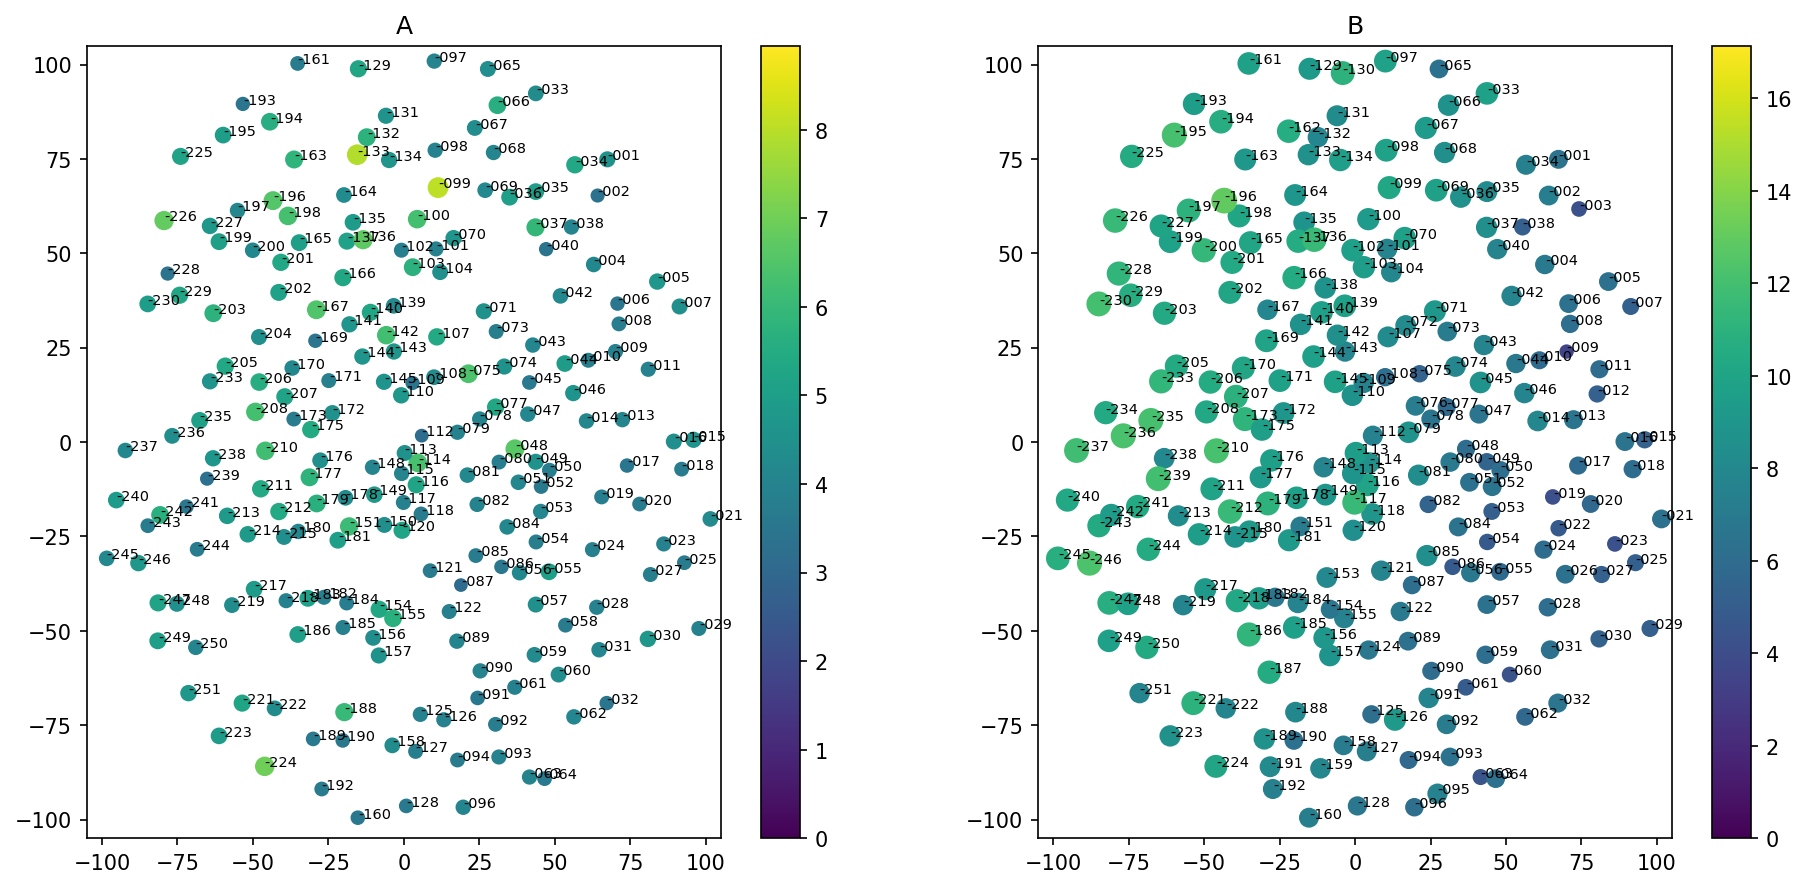

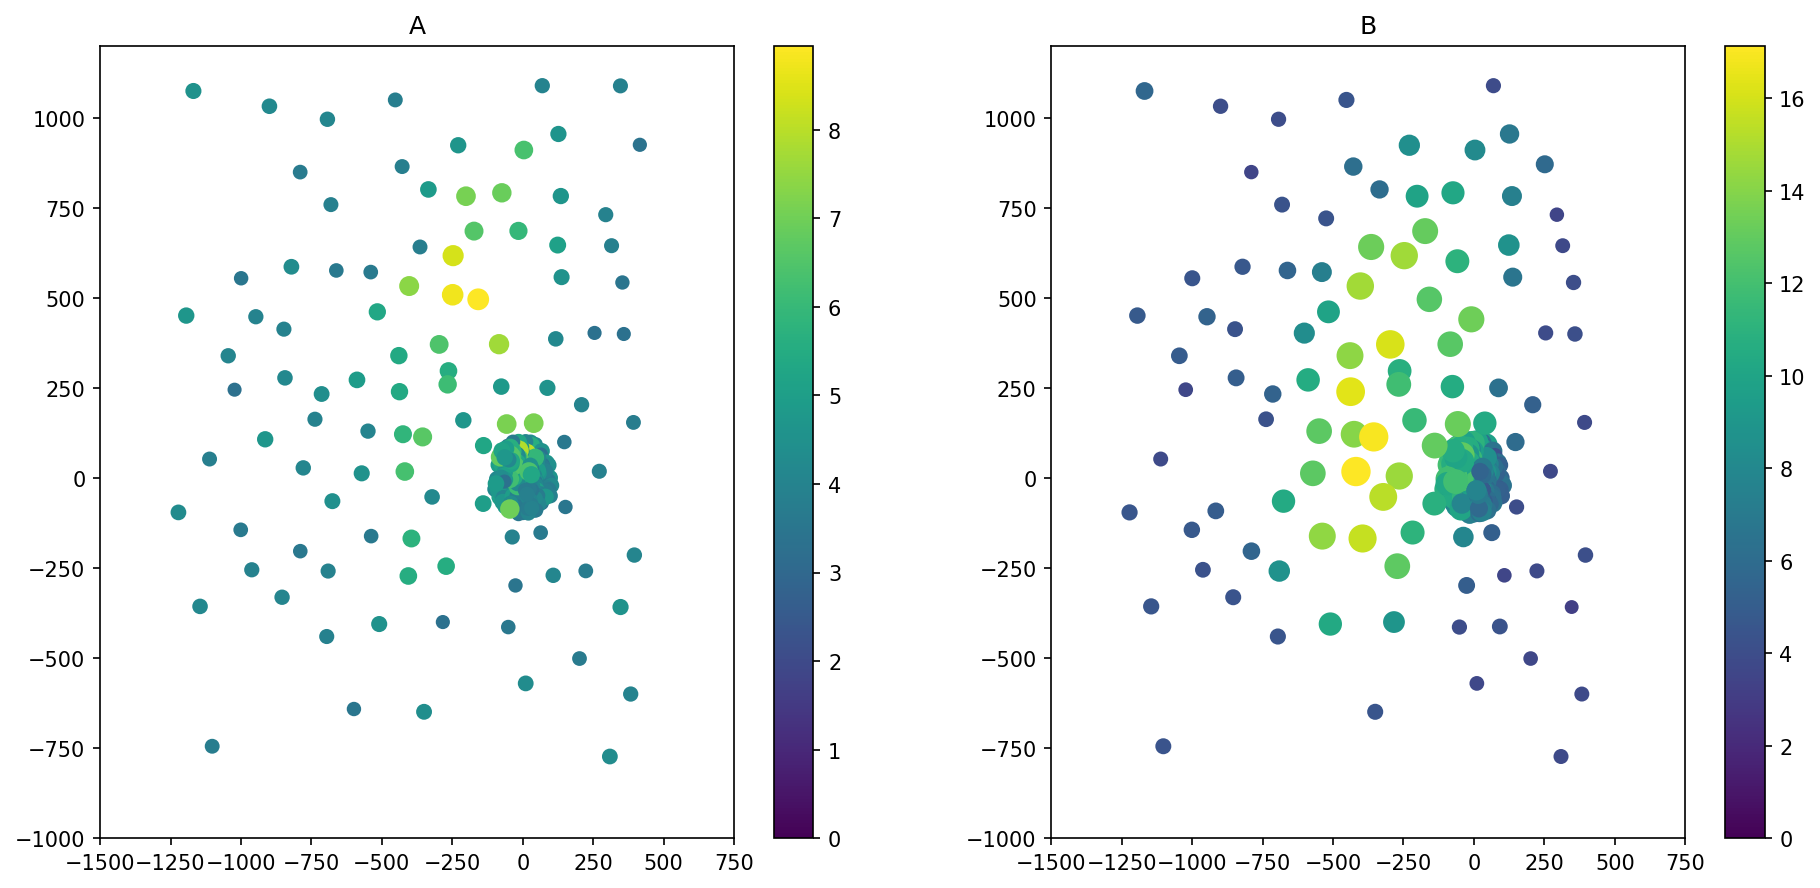

In [3]:
datafile='/lustre/kplant/2024February21/overnight1708578552.9377766.dat'
index_in_file=308374
config='/lustre/kplant/2024February21-dataproducts/config_preliminary_cuts.yml'

with open(config, 'r') as file:
    configuration=yaml.safe_load(file)
#array_map_filename=configuration['array_map_filename'] 
array_map_filename='/home/kplant/lwa-cosmic-rays/array-map-5-22-2023.csv'

lwa_df = reading.read_antpos()
namedict=build_mapping_dictionary(lwa_df)

array_map=pd.read_csv(array_map_filename)
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

fs= 197 #MHz


event_records=parsefile(datafile,start_ind=index_in_file,end_ind=704 )
event_summary=summarize_signals(event_records,np.asarray(configuration['filter']),namedict,xdict,ydict,zdict)

event_summary_flagged=flag_antennas(event_summary,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                    configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],10,
['LWA-288A', 'LWA-288B', 'LWA-147A', 'LWA-147B'])[0]

plt.figure(figsize=(15,7),dpi=150)
plt.subplot(121)
plt.title('A')
event_scatter_plot(event_summary_flagged,'snr',-105,105,-105,105,'A',annotate=True,markerscale=10,scale='linear',colorlimits='auto')
plt.subplot(122)
plt.title('B')
event_scatter_plot(event_summary_flagged,'snr',-105,105,-105,105,'B',annotate=True,markerscale=10,scale='linear',colorlimits='auto')

plt.figure(figsize=(15,7),dpi=150)
plt.subplot(121)
plt.title('A')
event_scatter_plot(event_summary_flagged,'snr',-1500,750,-1000,1200,'A',annotate=False,markerscale=10,scale='linear',colorlimits='auto')
plt.subplot(122)
plt.title('B')
event_scatter_plot(event_summary_flagged,'snr',-1500,750,-1000,1200,'B',annotate=False,markerscale=10,scale='linear',colorlimits='auto')
 

### Plane fit

Reference antenna LWA-177
[ 61.50759478 360.        ] [[7.80737901 1.79607539]
 [1.79607539 3.88606006]]
65.09378758622056


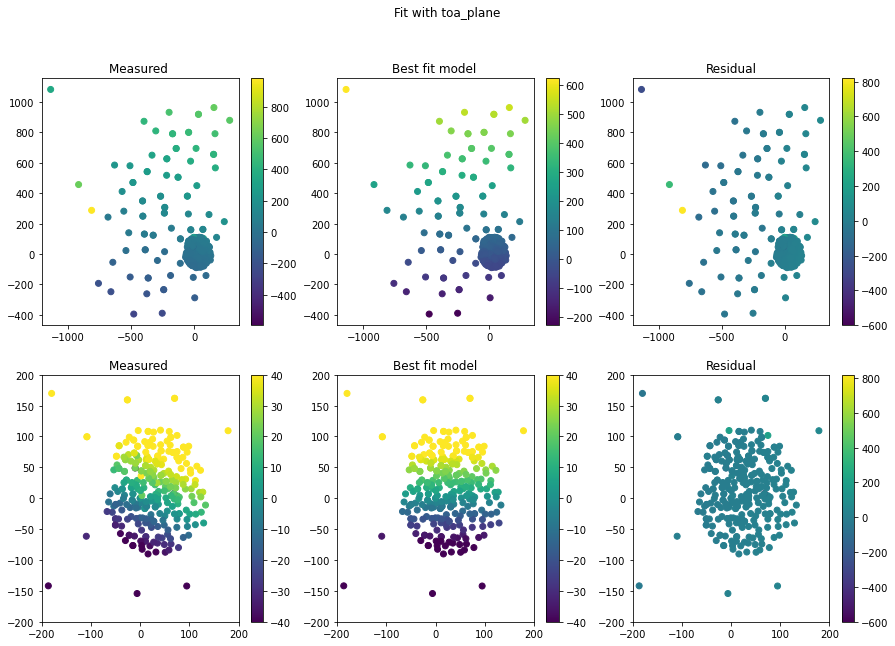

In [4]:
bright_summary=event_summary_flagged[event_summary_flagged['snr']>5]

popt,pcov,residual,reference=simple_direction_fit(bright_summary,plot=True,)


rms_residual=np.sqrt(np.mean(np.square(residual)))
print(popt,pcov)
print(rms_residual)



Reference antenna LWA-177
[ 59.25803037 360.        ] [[3.63379189 0.90357544]
 [0.90357544 2.02014633]]
65.16360267127291


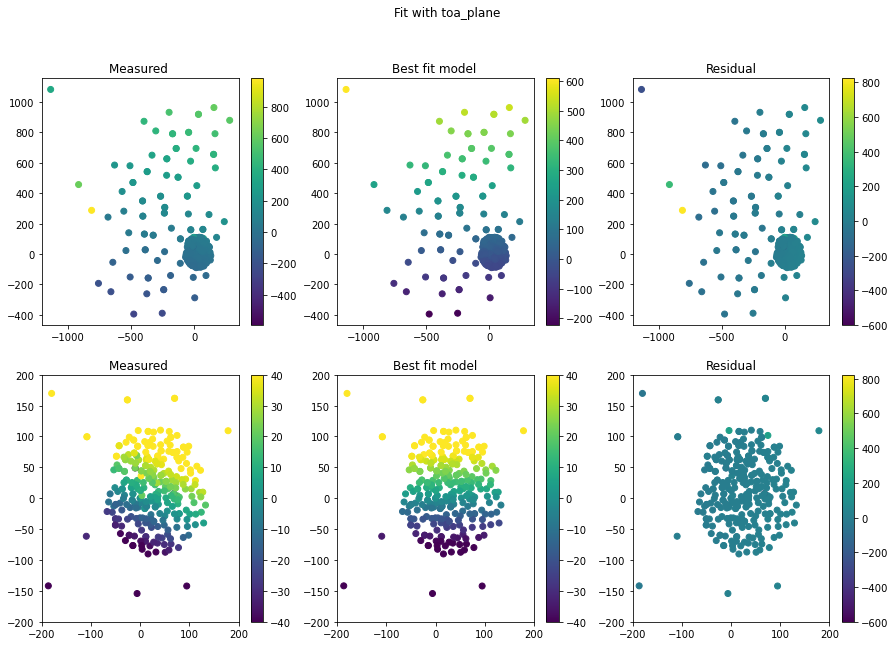

In [5]:
bright_summary=event_summary_flagged[event_summary_flagged['snr']>5]

popt,pcov,residual,reference=simple_direction_fit(bright_summary,plot=True,weightbysnr=True)


rms_residual=np.sqrt(np.mean(np.square(residual)))
print(popt,pcov)
print(rms_residual)

In [6]:
#verify residual calculation above

x=bright_summary['x'] - reference[0]
y=bright_summary['y'] - reference[1]
z=bright_summary['z'] - reference[2]
t=bright_summary['tpeak_rel'] -reference[3]

ant_coords=np.zeros((3,len(x)))
ant_coords[0,:]=x
ant_coords[1,:]=y
ant_coords[2,:]=z

best_model_toas=toa_plane(ant_coords,*popt)
print(np.sqrt(np.mean(np.square(t-best_model_toas))))

65.16360267127291


Reference antenna LWA-177
iteration:  0  rms residual:  65.16360267127291  n outliers:  37
popt:  [ 59.25803037 360.        ]
pcov:  [[3.63379189 0.90357544]
 [0.90357544 2.02014633]]
Reference antenna LWA-177
iteration:  1  rms residual:  13.598426963440554  n outliers:  8
popt:  [ 57.50602 360.     ]
pcov:  [[0.46237333 0.20350567]
 [0.20350567 0.42795428]]
Reference antenna LWA-177
iteration:  2  rms residual:  12.377270094852665  n outliers:  0
popt:  [ 56.67321298 360.        ]
pcov:  [[0.40738563 0.24502589]
 [0.24502589 0.50699304]]


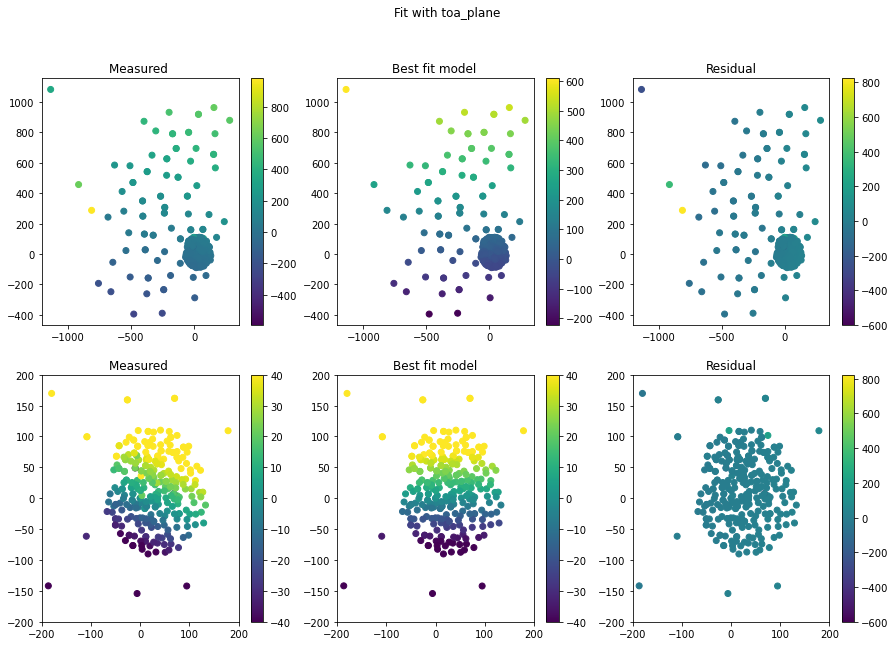

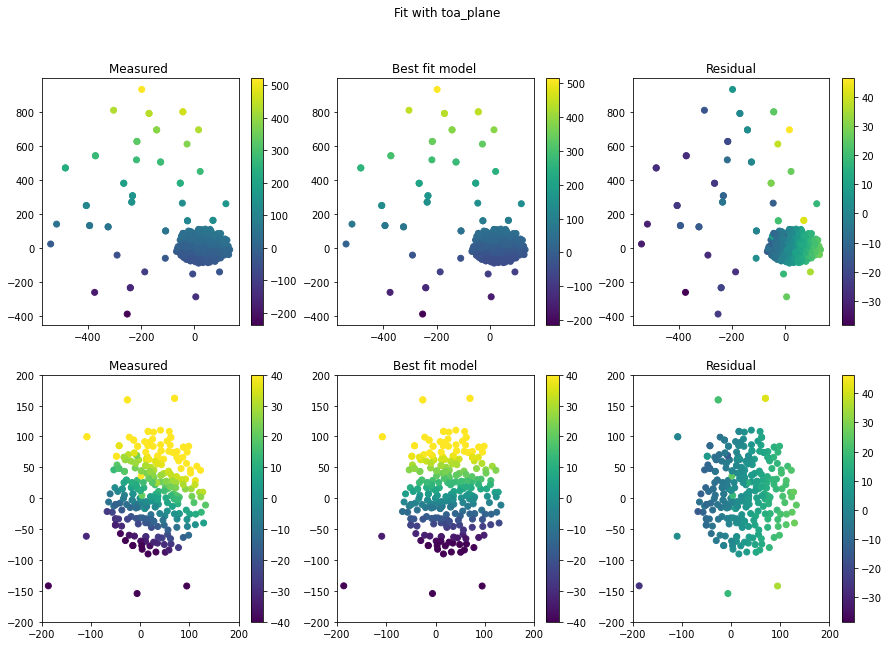

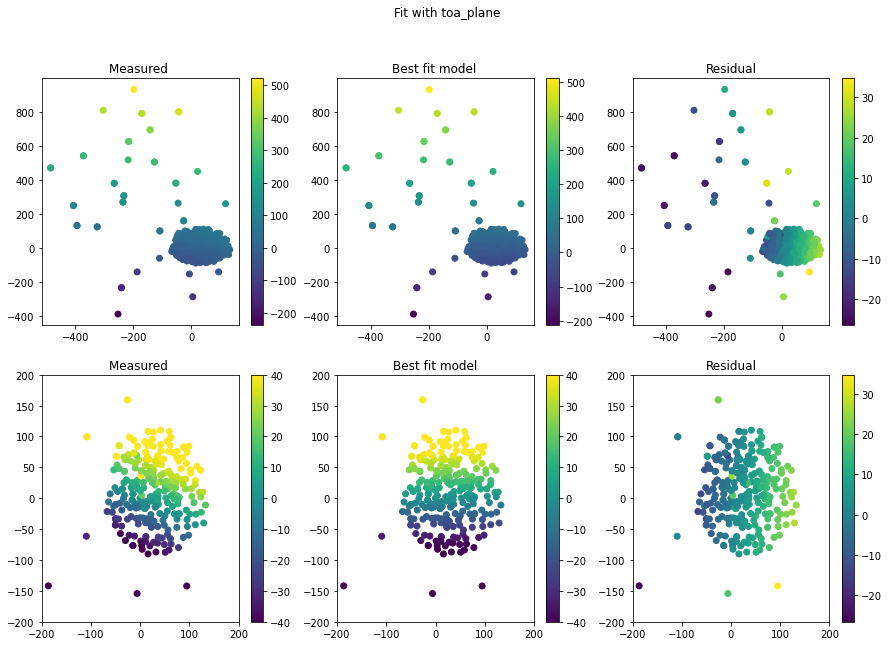

In [7]:
popt,pcov,rms_residual,weighted_rms_residual,current_ant_summary_array,reference=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>5],niter=3,outlier_limit=4,plot=True,weightbysnr=True)

In [8]:
#verify residual calculation
print(rms_residual)

x=current_ant_summary_array['x'] - reference[0]
y=current_ant_summary_array['y'] - reference[1]
z=current_ant_summary_array['z'] - reference[2]
t=current_ant_summary_array['tpeak_rel'] -reference[3]

ant_coords=np.zeros((3,len(x)))
ant_coords[0,:]=x
ant_coords[1,:]=y
ant_coords[2,:]=z

best_model_toas=toa_plane(ant_coords,*popt)
print(np.sqrt(np.mean(np.square(t-best_model_toas))))

12.377270094852665
12.377270094852665


## Spherical fit

In [9]:
def toa_sphere(ant_coords,theta,phi,r):
    #This calculates the arrival times at each antenna of a spherical wave moving across the array
    #The TOAs are returned in number of clock cycles relative to the arrival time at the origin
    #It is convenient to pick a reference antenna to define the origin and then work with antenna coordinates and arrival times with respect to that antenna
    #theta and phi in degrees
    #r and antenna coordinates in meters
    #theta is the angle between the source direction and zenith. Theta=0 for a zenith source
    #phi is the azimuth angle of the source
    
    c=3e8 #meters per second
    sample_rate=1.96e8 #MHz
    phi_rad=(phi*math.pi/180)
    theta_rad=theta*math.pi/180
    x,y,z=ant_coords
    
    #convert source position to cartesian coordinates 
    ys=r*math.sin(theta_rad)*math.cos(phi_rad)
    xs=r*math.sin(theta_rad)*math.sin(phi_rad)
    zs=r*math.cos(theta_rad)
    
    #distance from source to antenna
    d=np.sqrt(((x-xs)**2)+((y-ys)**2)+((z-zs)**2))
    
    #arrival time at antenna
    t=(1/c)*(d-r)
    
    #convert time to a number of clock cycles offset from the arrival time at the origin
    time_diff=t*sample_rate
    return time_diff

Reference antenna LWA-177


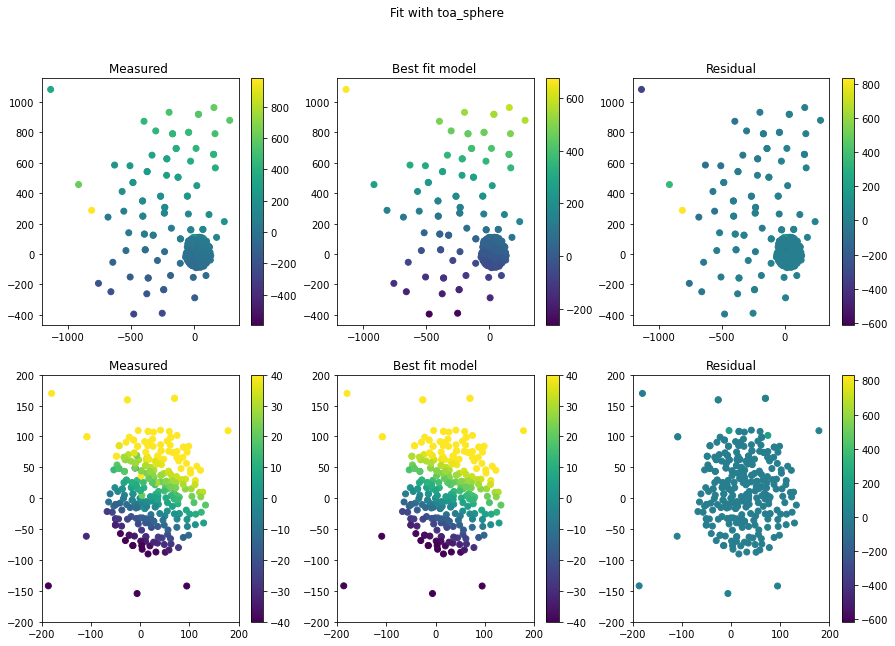

In [10]:
popt,pcov,res,reference=simple_direction_fit(event_summary_flagged[event_summary_flagged['snr']>5],toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e5]),plot=True,weightbysnr=True)

In [11]:


#verify residual calculation above
bright_summary=event_summary_flagged[event_summary_flagged['snr']>5]
x=bright_summary['x'] - reference[0]
y=bright_summary['y'] - reference[1]
z=bright_summary['z'] - reference[2]
t=bright_summary['tpeak_rel'] -reference[3]

ant_coords=np.zeros((3,len(x)))
ant_coords[0,:]=x
ant_coords[1,:]=y
ant_coords[2,:]=z

best_model_toas=toa_sphere(ant_coords,*popt)
print(np.sqrt(np.mean(np.square(t-best_model_toas))))
print(np.sqrt(np.mean(np.square(res))))

63.72021405012809
63.72021405012809


Reference antenna LWA-177
iteration:  0  rms residual:  63.72019594944545  n outliers:  80
popt:  [  63.84448853  197.35822509 1710.81154651]
pcov:  [[ 7.14248962e+00  1.40274086e+00 -1.43232360e+02]
 [ 1.40274086e+00  1.04799015e+01 -1.67005453e+03]
 [-1.43232360e+02 -1.67005453e+03  3.08290621e+05]]
Reference antenna LWA-177
iteration:  1  rms residual:  1.6680329523769037  n outliers:  12
popt:  [  62.06960854  198.84819424 1377.14314845]
pcov:  [[ 3.87376402e-02  2.84440360e-03 -1.78864541e-01]
 [ 2.84440360e-03  5.00930556e-02 -6.30323813e+00]
 [-1.78864541e-01 -6.30323813e+00  9.31690878e+02]]
Reference antenna LWA-177
iteration:  2  rms residual:  5.623584489356265  n outliers:  2
popt:  [6.21192021e+01 1.89934288e+02 9.96206522e+07]
pcov:  [[ 3.36799956e-01  3.70312987e-02 -3.72529887e+06]
 [ 3.70312987e-02  8.92935740e-02  2.12786780e+04]
 [-3.72529887e+06  2.12786780e+04  5.28621281e+15]]


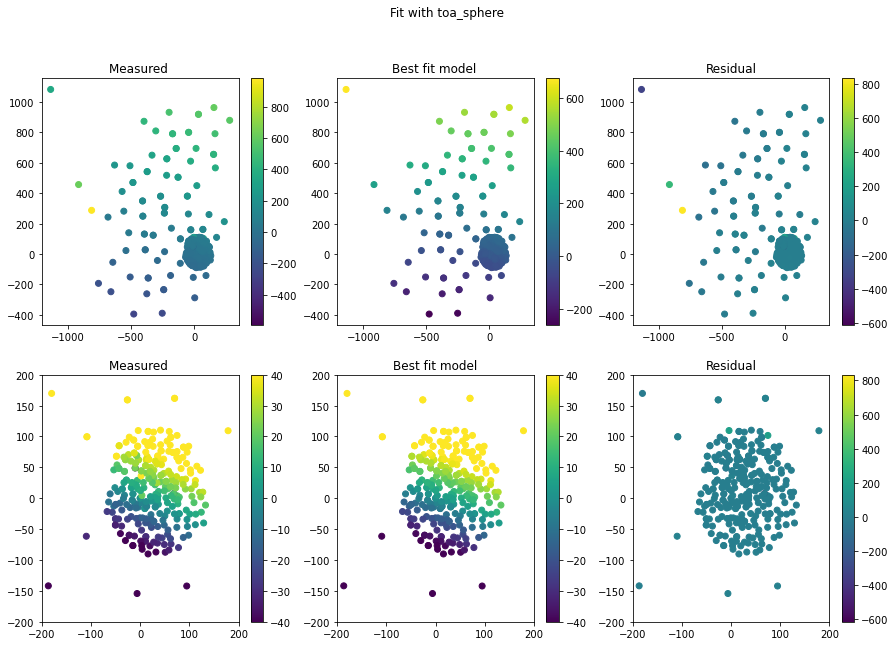

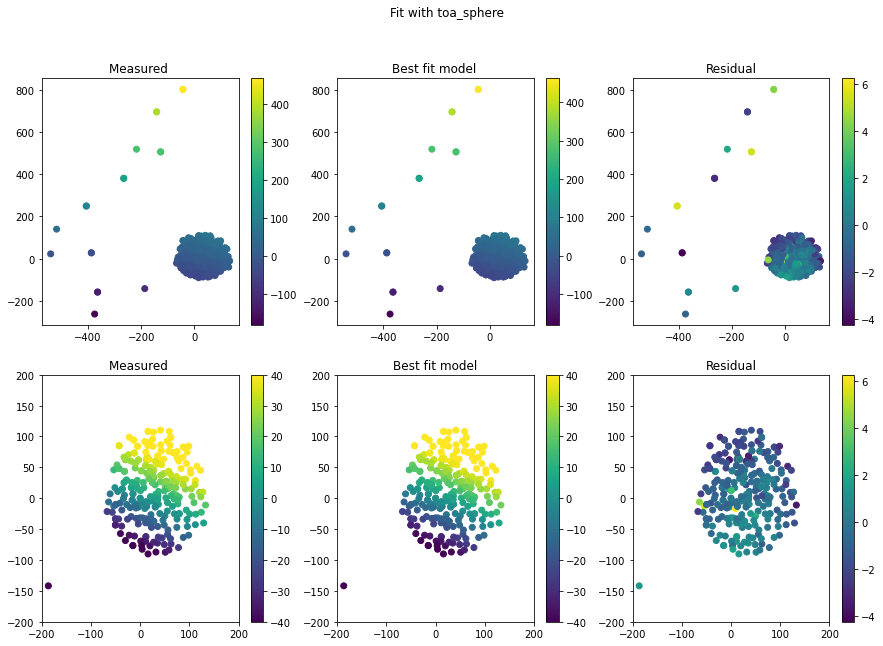

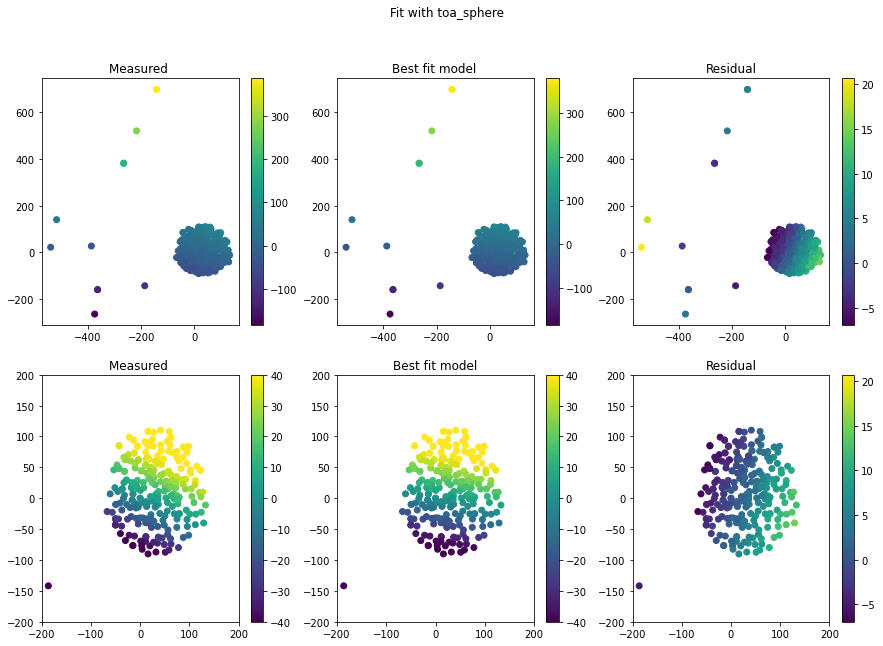

In [12]:
popt,pcov,rms_res,weighted_rms_residual,current_ant_summary_array,reference=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>5],niter=3,outlier_limit=4,plot=True,toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e8]),weightbysnr=True)

Reference antenna LWA-177
iteration:  0  rms residual:  40.080207975548866  n outliers:  33
popt:  [6.58341178e+01 1.91097914e+02 8.73410142e+06]
pcov:  [[ 3.48537782e+00  6.31705005e-01  5.15372444e+07]
 [ 6.31705005e-01  9.81994067e-01 -9.70566697e+07]
 [ 5.15372444e+07 -9.70566697e+07  1.02046244e+17]]
Reference antenna LWA-177
iteration:  1  rms residual:  6.193399849276047  n outliers:  3
popt:  [6.37725717e+01 1.89992639e+02 9.93989962e+07]
pcov:  [[1.70548182e-01 3.50709506e-02 2.13771050e+06]
 [3.50709506e-02 5.61887431e-02 7.21866671e+06]
 [2.13771050e+06 7.21866671e+06 9.35818089e+15]]
Reference antenna LWA-177
iteration:  2  rms residual:  5.923211396398217  n outliers:  0
popt:  [6.36479007e+01 1.90000188e+02 9.98962737e+07]
pcov:  [[ 1.54006221e-01  2.67410494e-02 -6.11484323e+06]
 [ 2.67410494e-02  4.58121911e-02  3.37543710e+06]
 [-6.11484323e+06  3.37543710e+06  8.97038691e+15]]


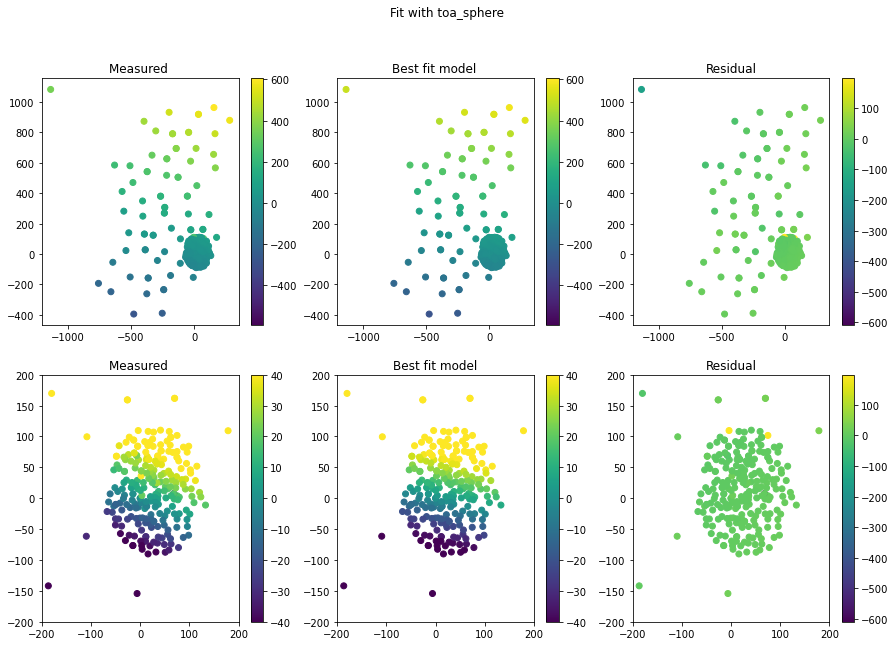

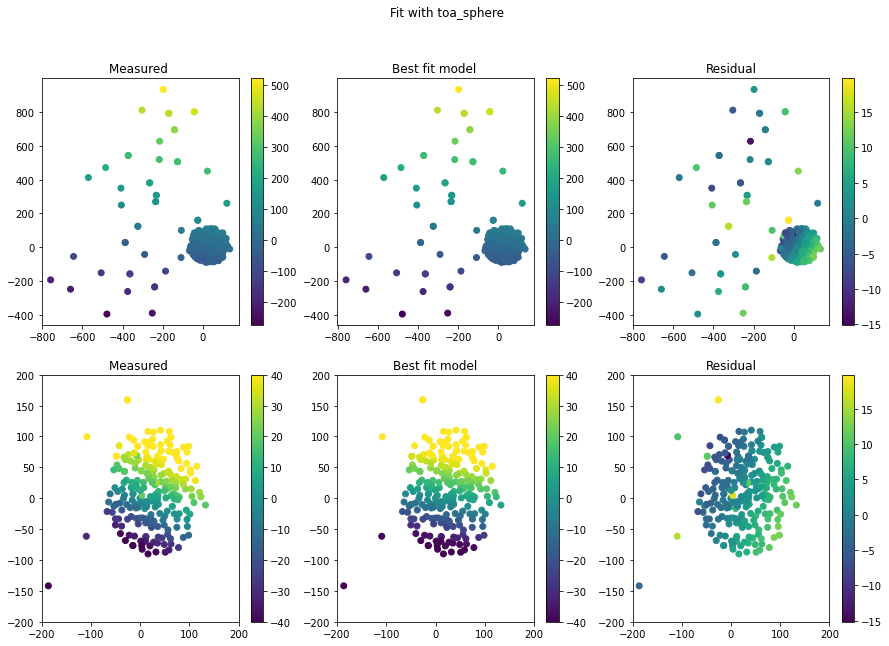

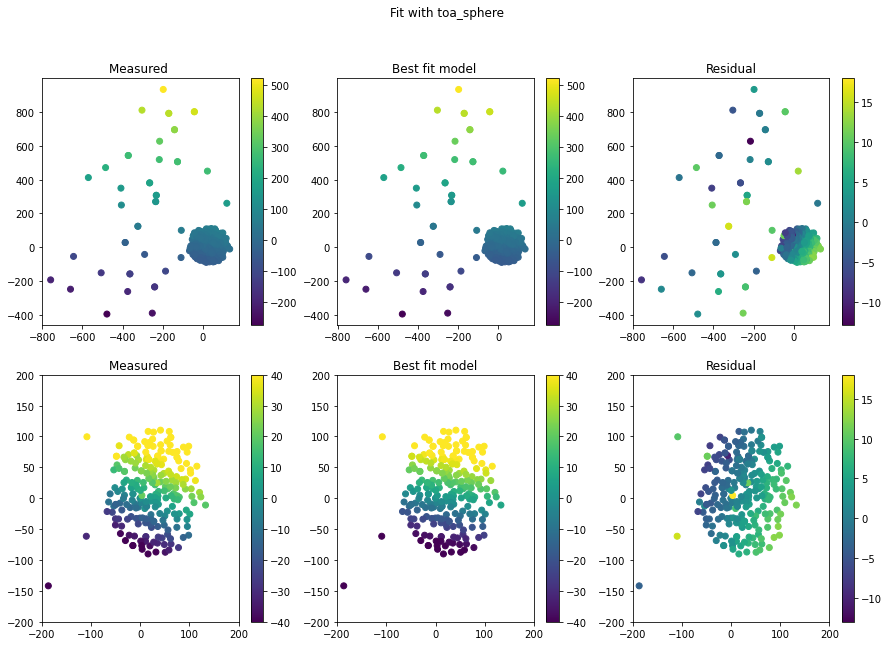

In [4]:
popt,pcov,rms_res,weighted_rms_residual,current_ant_summary_array,reference=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>5.5],niter=3,outlier_limit=4,plot=True,toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e8]),weightbysnr=True)

Reference antenna LWA-177
iteration:  0  rms residual:  41.07208390787451  n outliers:  32
popt:  [   65.53193445   191.74089553 10572.10634258]
pcov:  [[ 4.60027026e+00 -1.07892714e+00  1.44461450e+04]
 [-1.07892714e+00  9.54957397e+00 -6.59632820e+04]
 [ 1.44461450e+04 -6.59632820e+04  5.12993461e+08]]
Reference antenna LWA-177
iteration:  1  rms residual:  5.918980286580431  n outliers:  1
popt:  [6.44650372e+01 1.89980085e+02 6.04140675e+07]
pcov:  [[ 1.71972877e-01  3.15648739e-02  2.85890103e+06]
 [ 3.15648739e-02  5.01307389e-02 -3.05320729e+06]
 [ 2.85890103e+06 -3.05320729e+06  1.49342620e+16]]
Reference antenna LWA-177
iteration:  2  rms residual:  5.705153847158563  n outliers:  1
popt:  [6.40343174e+01 1.89931933e+02 2.11977151e+07]
pcov:  [[ 1.76800228e-01  2.54062529e-02 -3.47870534e+06]
 [ 2.54062529e-02  5.11976788e-02  2.30506112e+06]
 [-3.47870534e+06  2.30506112e+06  1.35218389e+15]]


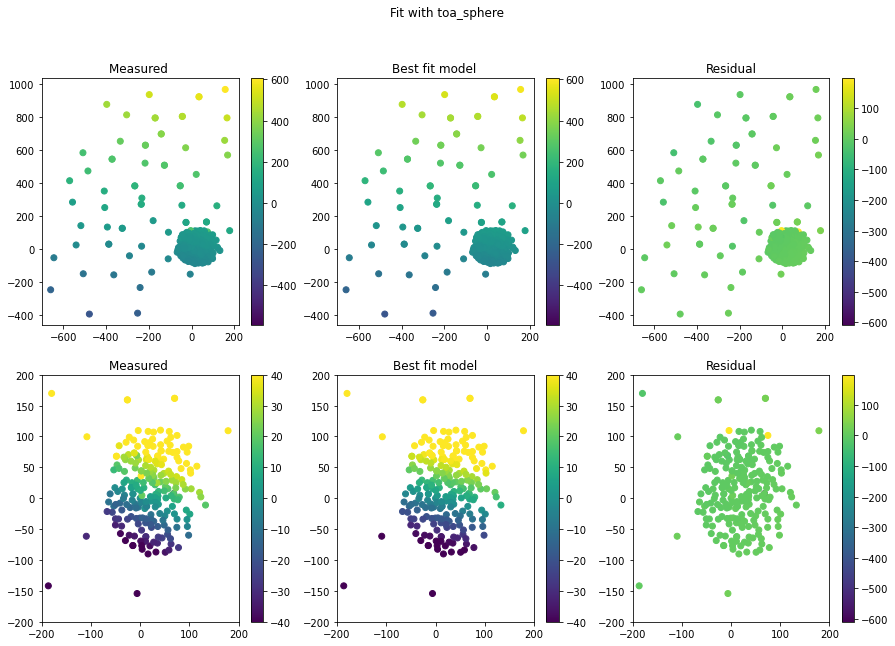

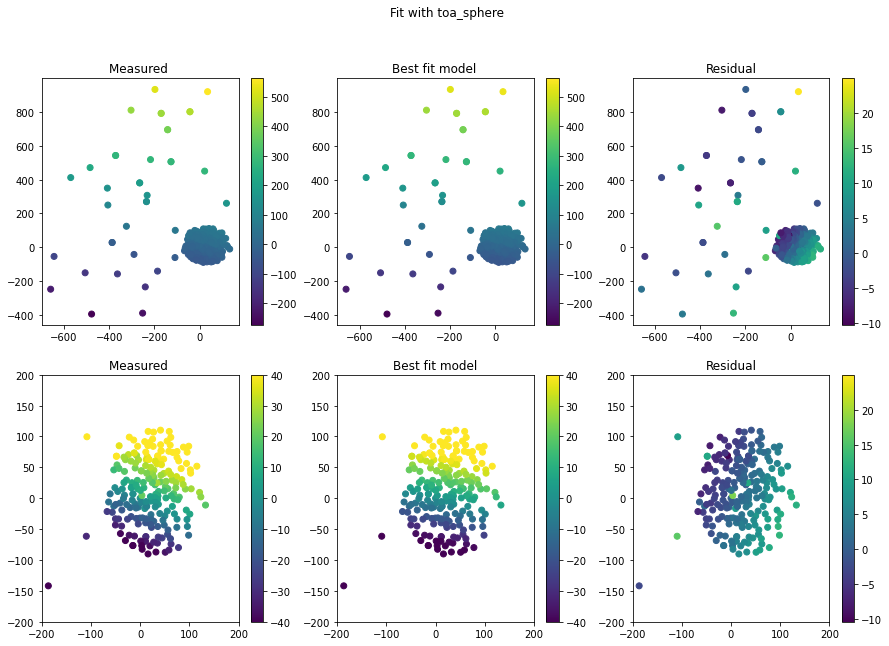

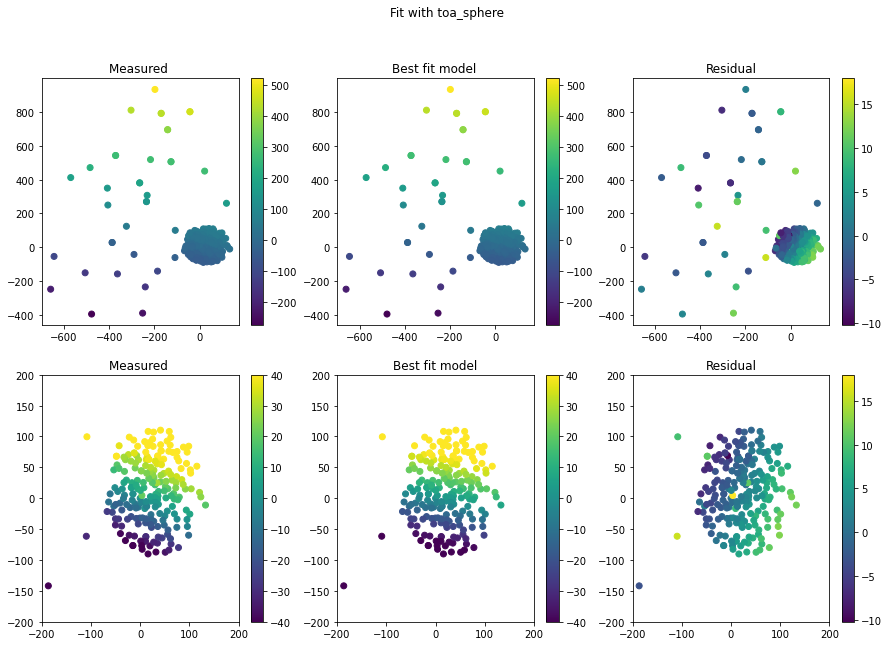

In [5]:
popt,pcov,rms_res,weighted_rms_residual,current_ant_summary_array,reference=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>6],niter=3,outlier_limit=4,plot=True,toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e8]),weightbysnr=True)

Reference antenna LWA-177
iteration:  0  rms residual:  41.051113924998845  n outliers:  33
popt:  [   66.66396224   191.94311949 18624.91477149]
pcov:  [[ 8.45432583e+00 -2.07156610e+00  9.29012386e+04]
 [-2.07156610e+00  1.39812177e+01 -2.84314111e+05]
 [ 9.29012386e+04 -2.84314111e+05  6.96877317e+09]]
Reference antenna LWA-177
iteration:  1  rms residual:  4.8474022812092254  n outliers:  20
popt:  [  65.10068929  196.02940906 2842.08438193]
pcov:  [[ 1.62280741e-01  1.73464741e-02  5.75645883e+00]
 [ 1.73464741e-02  2.70566379e-01 -1.24281264e+02]
 [ 5.75645883e+00 -1.24281264e+02  6.95288655e+04]]
Reference antenna LWA-177
iteration:  2  rms residual:  4.637270642223036  n outliers:  1
popt:  [6.49452600e+01 1.91623700e+02 7.14609444e+07]
pcov:  [[ 1.82604997e-01  5.02232614e-02 -4.04927871e+06]
 [ 5.02232614e-02  7.25656817e-02  5.09451387e+05]
 [-4.04927871e+06  5.09451387e+05  3.20190289e+15]]


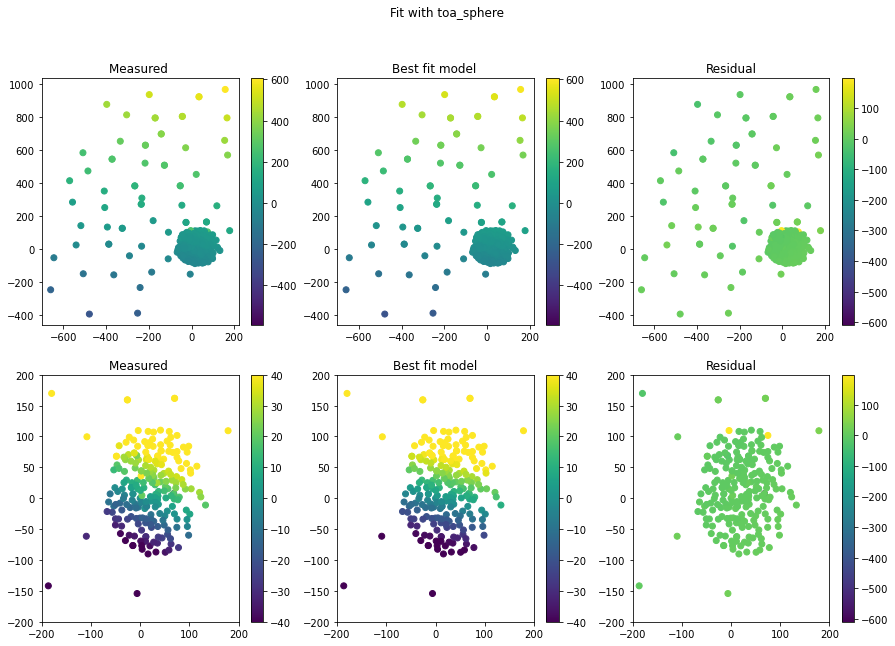

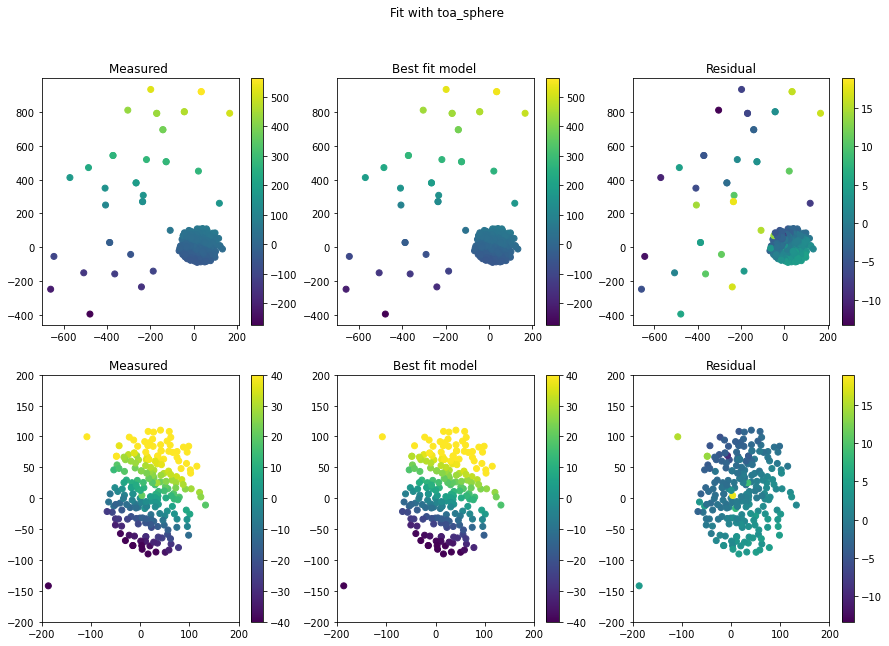

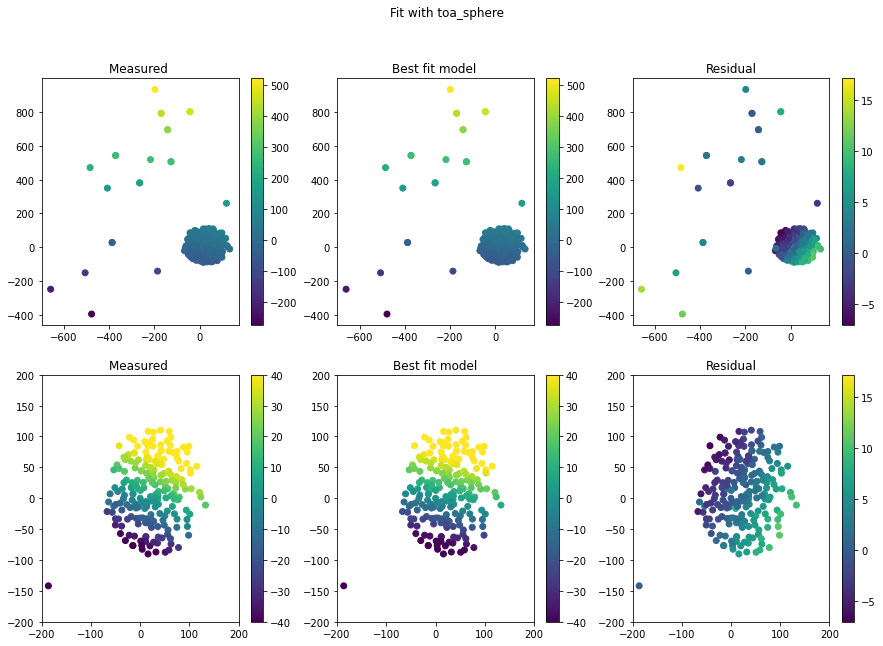

In [6]:
popt,pcov,rms_res,weighted_rms_residual,current_ant_summary_array,reference=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>6],niter=3,outlier_limit=4,plot=True,toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e8]),weightbysnr=False)

In [13]:
#verify residual calculation
print(rms_res)
print(weighted_rms_residual)

x=current_ant_summary_array['x'] - reference[0]
y=current_ant_summary_array['y'] - reference[1]
z=current_ant_summary_array['z'] - reference[2]
t=current_ant_summary_array['tpeak_rel'] -reference[3]

ant_coords=np.zeros((3,len(x)))
ant_coords[0,:]=x
ant_coords[1,:]=y
ant_coords[2,:]=z

best_model_toas=toa_sphere(ant_coords,*popt)
residual=t-best_model_toas
print(np.sqrt(np.mean(np.square(residual))))

w=1/current_ant_summary_array['snr']
weights=(w)/np.mean(w)
weightedresidual=residual/weights

print(np.sqrt(np.mean(np.square(weightedresidual)))) #sqrt of chi square


5.623584489356265
5.914515363349271
5.623584489356265
5.914515363349271


## Scratch

In [14]:

x=bright_summary['x'] - bright_summary['x'][0]
y=bright_summary['y'] - bright_summary['y'][0]
z=bright_summary['z'] - bright_summary['z'][0]
t=bright_summary['tpeak_rel'] - bright_summary['tpeak_rel'][0]
print('Reference antenna',bright_summary['antname'][0])
ant_coords=np.zeros((3,len(x)))
ant_coords[0,:]=x
ant_coords[1,:]=y
ant_coords[2,:]=z

Reference antenna LWA-177


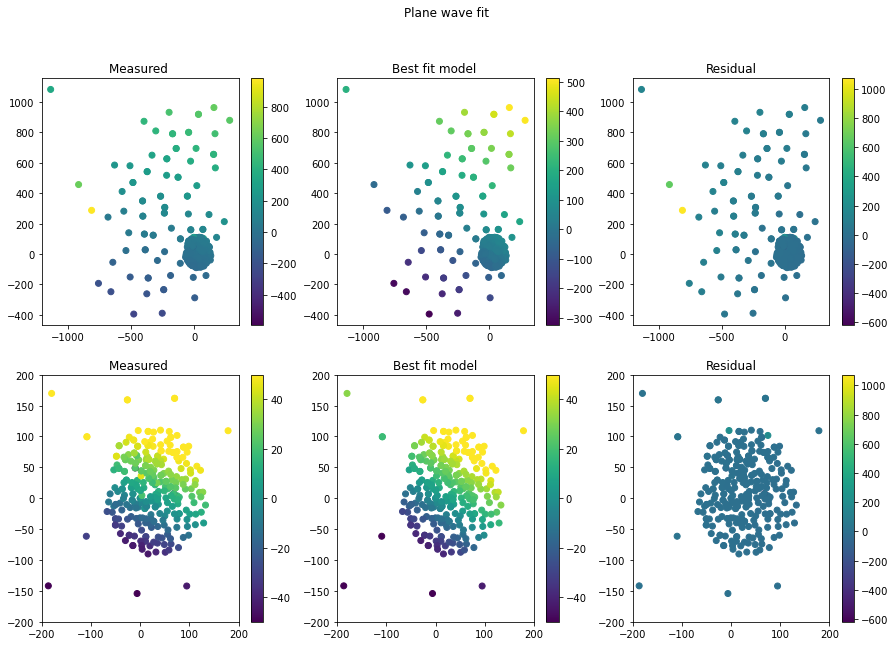

In [15]:
th=58.9
ph=30
best_model_toas=toa_plane(ant_coords,th,ph)
residual=t-best_model_toas


#plot the results
czoom_min=-50
czoom_max=50
title='Plane wave fit'
plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)

In [16]:
rms_residual=np.sqrt(np.mean(np.square(residual)))
print(rms_residual)

86.02987000010411
